## Create Advasarial Attack on Linear model

### Data
* Apooge toy data

### Method 
* FGSM
https://adversarial-ml-tutorial.org/adversarial_examples/
    - adjust in the direction of gradient
    - in order to maximize loss, adjust in the direction of gradient 

* random_attack
* PGD with random restart: 

### Model
* label = W * flux
* batch size 128
* optimizer adam
* learning rate 0.001,0.5
* epoch: converges after ~20

### to do - tweak parameters 
* decrease epsilon to 0.01
* try to adapt fsgm
* Find top examples
* visaulization like deep neural network
* add bias term on flux
* alpha = step size (does it matter?)
* MSE for different learning rate/step sizes

* Once we decide on the new data, rerun everything on new data.
* 3d plot with one configuration showing before after perturbation
* per example plot showing worst 5 examples (true point, random attack, pgd, per example pgd)
* rmse trend of different step size

### Findings
* Perterbed labels are lower in values 

### Plots
*  
['2d_plot'](#2d_plot)
* ['example_attack_plot'](#example_attack_plot)
* ['banner_plot'](#banner_plot)

## Setup

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from mpl_toolkits.mplot3d import Axes3D
from astroNN.datasets import H5Loader
import os

/anaconda3/envs/tf.1.4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/tf.1.4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/tf.1.4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/tf.1.4/lib/python3.6/site-packages/tensorflow/python/framework/dty

## Read Data

In [2]:
loader = H5Loader('/Users/nhuang37/Desktop/NYU DS/Yr 2 Sem1/Capstone/AstroNN/astroNN_spectra_paper_figures/__train_r_giant_1k_8575_1125_1557.h5')
loader.load_err = True
loader.target = ['teff', 'logg', 'C', 'C1', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'K',
                  'Ca', 'Ti', 'Ti2', 'V', 'Cr', 'Mn', 'Fe','Co', 'Ni']
x,y,x_err,y_err = loader.load()

/anaconda3/envs/tf.1.4/lib/python3.6/site-packages/astroNN/datasets/h5.py:581: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(self.h5path) as F:  # ensure the file will be cleaned up
/anaconda3/envs/tf.1.4/lib/python3.6/site-packages/astroNN/datasets/h5.py:613: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(self.h5path) as F:  # ensure the file will be cle

In [3]:
print(x.shape)
print(y.shape)

(1000, 8575)
(1000, 22)


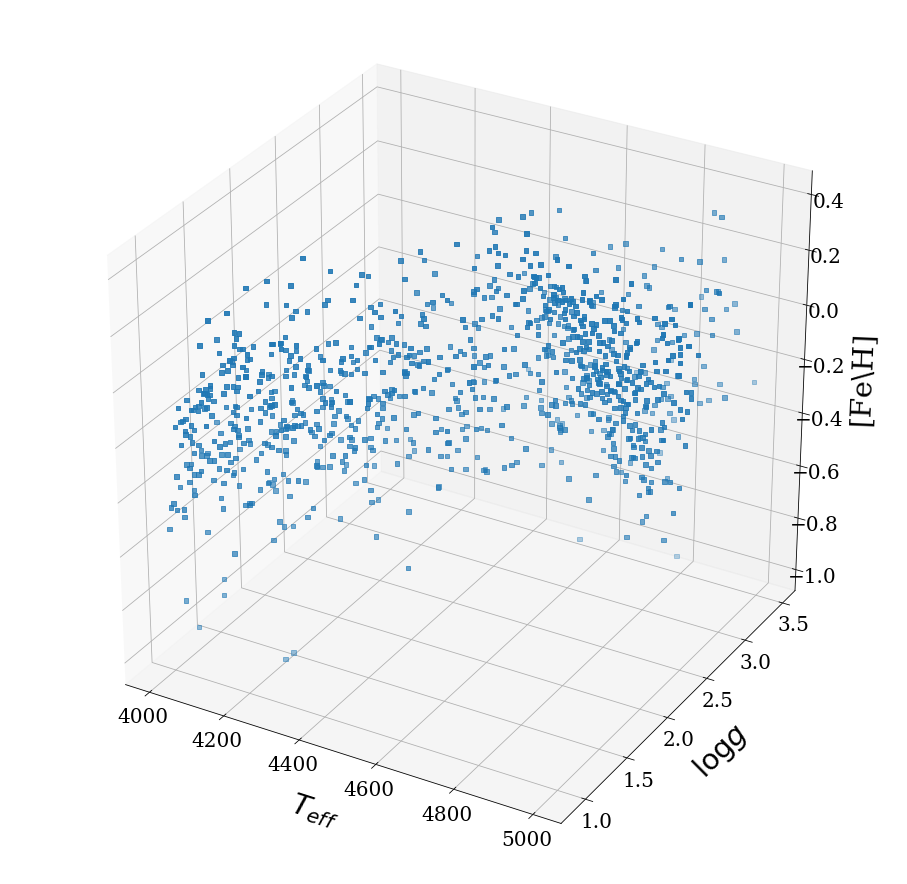

In [528]:
# Plot of 1000 stars
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111,projection='3d')
ax.set_xlabel('$T_{eff}$',fontsize='x-large',labelpad=20)
ax.set_ylabel('$\log g$',fontsize='x-large',labelpad=20)
ax.set_zlabel('[Fe\H]',fontsize='x-large',labelpad=20)
ax.scatter(y[:,0],y[:,1],y[:,19],marker='s')

## Pre-processing


In [4]:
def add_bias_term(flux_vals):
    ## generate new features
    nstars = flux_vals.shape[0]
    nlabels = flux_vals.shape[1]
    bias_term = np.ones((nstars,1))
    linear_terms = flux_vals
    lvec = np.hstack((bias_term,linear_terms))
    return lvec
def scale_dataset(label_vals):
    ## scale
    scales = {}
    
    # bottom 2.5%
    two5 = np.percentile(label_vals,2.5,axis=0)
    outlier_list_lower = np.where(tr_label < two5)
    # above 97.5%
    nine75 = np.percentile(label_vals,97.5,axis=0)
    outlier_list_upper = np.where(tr_label > nine75)
    
    # save for rescaling
    scales['two5'] = two5
    scales['nine75'] = nine75
    
    # replace above 97.5% with 97.5%
    for idx,col in zip(outlier_list_upper[0],outlier_list_upper[1]):
        label_vals[idx,col] = nine75[col]
    # replace below 2.5% with 2.5%
    for idx,col in zip(outlier_list_lower[0],outlier_list_lower[1]):
        label_vals[idx,col] = two5[col]
        
    # transform to {-1,1}
    for i in range(label_vals.shape[1]):
        label_vals[:,i] = np.interp(label_vals[:,i], (label_vals[:,i].min(), label_vals[:,i].max()), (-1, +1))

    return label_vals, scales

# rescale labels 
def rescale(y,minx,maxx):
    return ((maxx-minx)*y + (maxx+minx))/2

def rescale_dataset(scaled_labels,scales,n):
    prediction_rescale = np.zeros((n,3))
    for i in range(scaled_labels.shape[1]):
        prediction_rescale[:,i] = rescale(scaled_labels[:,i],scales['two5'][i],scales['nine75'][i])
    return prediction_rescale

In [5]:
from copy import deepcopy
tr_label = y[:,[0,1,19]]
labels,scales = scale_dataset(y[:,[0,1,19]])
labels[0]

array([-0.03450568, -0.2199393 , -0.49218544], dtype=float32)

In [6]:
tr_label[0]

array([ 4.4800527e+03,  1.8559592e+00, -2.9007456e-01], dtype=float32)

In [7]:
labels,scales = scale_dataset(tr_label)
labels[0]

array([-0.03450568, -0.2199393 , -0.49218544], dtype=float32)

In [8]:
scales

{'two5': array([ 4.03497377e+03,  1.09133925e+00, -4.79262843e-01]),
 'nine75': array([4.95694478e+03, 3.05175064e+00, 2.65844878e-01])}

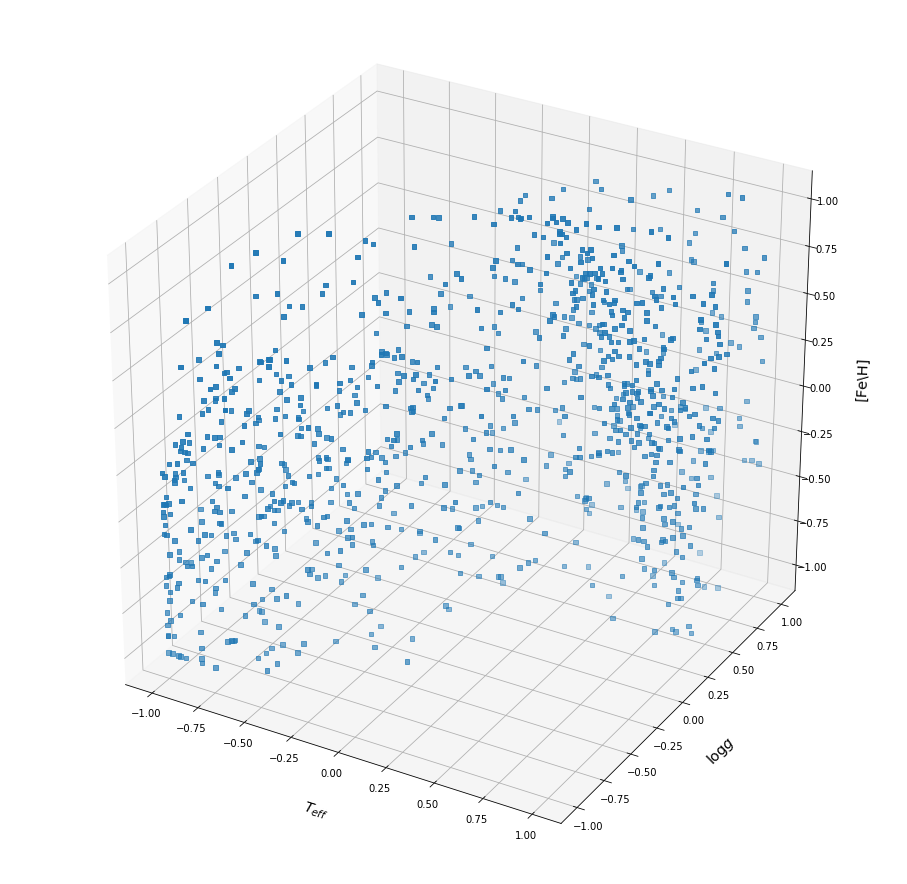

In [9]:
# Plot of 1000 stars after preprocessing
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111,projection='3d')
ax.set_xlabel('$T_{eff}$',fontsize='x-large',labelpad=20)
ax.set_ylabel('$\log g$',fontsize='x-large',labelpad=20)
ax.set_zlabel('[Fe\H]',fontsize='x-large',labelpad=20)
ax.scatter(labels[:,0],labels[:,1],labels[:,2],marker='s')

### Scale 1k star data

In [10]:
# for training, labels are scaled, flux are not, only add a bias term
tr_flux = deepcopy(x)

targets = torch.from_numpy(labels).type(torch.FloatTensor)
inputs = torch.from_numpy(tr_flux).type(torch.FloatTensor)

# Test,train split
train_ds = TensorDataset(inputs[:,:], targets[:,:])
#test_ds = TensorDataset(inputs[400:,:], targets[400:,:])

# Define data loader
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
#test_dl = DataLoader(test_ds, batch_size, shuffle=True)

In [12]:
rescaled_label = rescale_dataset(labels_1k,scales_1k,1000)
rescaled_label[0]

array([ 4.95694482e+03,  3.05175066e+00, -4.79262829e-01])

### Functions

In [13]:
def getrmse(y_pred,y_true):
    return(np.sqrt(np.mean(torch.dist(y_pred,y_true,p=2).numpy())))

## Modeling

In [14]:
model = nn.Linear(8575,3,bias= True)
# sgd optimizer cannot converge, will generate -inf and nan
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#model.weight.requires_grad = False
loss_fn = torch.nn.MSELoss() 

## Training

In [15]:
loss_list = []
# Define a utility function to train the model
def fit(num_epochs, model, loss_fn, optimizer):
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
            # Generate predictions
            #print(torch.sum(xb),torch.sum(yb))
            pred = model(xb.float())
            #print(pred)
            loss = loss_fn(pred, yb.float())
            # Perform gradient descent
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        Loss = loss_fn(model(inputs.float()), targets.float())
        loss_list.append(Loss)
        print('epoch {}, loss {}'.format(epoch,Loss))
    return loss_list        

In [16]:
# Train the model for 100 epochs
loss_list = fit(100, model, loss_fn, optimizer)

epoch 0, loss 7.430149555206299
epoch 1, loss 5.235835552215576
epoch 2, loss 0.5803642272949219
epoch 3, loss 1.4579380750656128
epoch 4, loss 0.41065070033073425
epoch 5, loss 0.48355376720428467
epoch 6, loss 0.32543691992759705
epoch 7, loss 0.3240169286727905
epoch 8, loss 0.30987483263015747
epoch 9, loss 0.29207319021224976
epoch 10, loss 0.29001104831695557
epoch 11, loss 0.2856072187423706
epoch 12, loss 0.275590181350708
epoch 13, loss 0.2722267806529999
epoch 14, loss 0.26743677258491516
epoch 15, loss 0.2775896191596985
epoch 16, loss 0.2574805021286011
epoch 17, loss 0.25268879532814026
epoch 18, loss 0.25737544894218445
epoch 19, loss 0.2727299630641937
epoch 20, loss 0.24224992096424103
epoch 21, loss 0.24445654451847076
epoch 22, loss 0.2312864065170288
epoch 23, loss 0.22497621178627014
epoch 24, loss 0.23628990352153778
epoch 25, loss 0.2139132171869278
epoch 26, loss 0.216757133603096
epoch 27, loss 0.2127428501844406
epoch 28, loss 0.21086947619915009
epoch 29, loss

In [17]:
for param in model.parameters():
    param.requires_grad = False

In [18]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.0087, -0.0057, -0.0051,  ...,  0.0038,  0.0105,  0.0062],
        [-0.0079,  0.0008,  0.0095,  ..., -0.0011, -0.0102,  0.0105],
        [ 0.0004,  0.0053, -0.0074,  ...,  0.0014,  0.0023,  0.0062]])
Parameter containing:
tensor([0.0067, 0.0011, 0.0020])


In [20]:
os.getcwd()

'/Users/nhuang37/Desktop/NYU DS/Yr 2 Sem1/Capstone/Eva'

In [21]:
# Save model 
torch.save(model.state_dict(),'linear_model_1k')

In [22]:
# load model
model.load_state_dict(torch.load('linear_model_1k'))
model.weight

Parameter containing:
tensor([[ 0.0087, -0.0057, -0.0051,  ...,  0.0038,  0.0105,  0.0062],
        [-0.0079,  0.0008,  0.0095,  ..., -0.0011, -0.0102,  0.0105],
        [ 0.0004,  0.0053, -0.0074,  ...,  0.0014,  0.0023,  0.0062]])

In [26]:
y_predi = []
for i in range(1000):
    y_predi.append(model.weight.detach().numpy()@tr_flux[i])

In [201]:
np.array(y_predi).shape

(1000, 3)

In [202]:
#eval dataloader
targets_1k = torch.from_numpy(np.array(y_predi)).type(torch.FloatTensor) ##use predictions as attack target
inputs_1k = torch.from_numpy(x).type(torch.FloatTensor)

eval_ds = TensorDataset(inputs_1k[:,:], targets_1k[:,:])

# Define data loader
batch_size = 1000
#train_dl = DataLoader(train_ds, batch_size, shuffle=True)
eval_dl = DataLoader(eval_ds, batch_size,shuffle=False) #shuffle=True will randomly change the order, should not use when training full batch
#eval_dl = DataLoader(eval_ds)

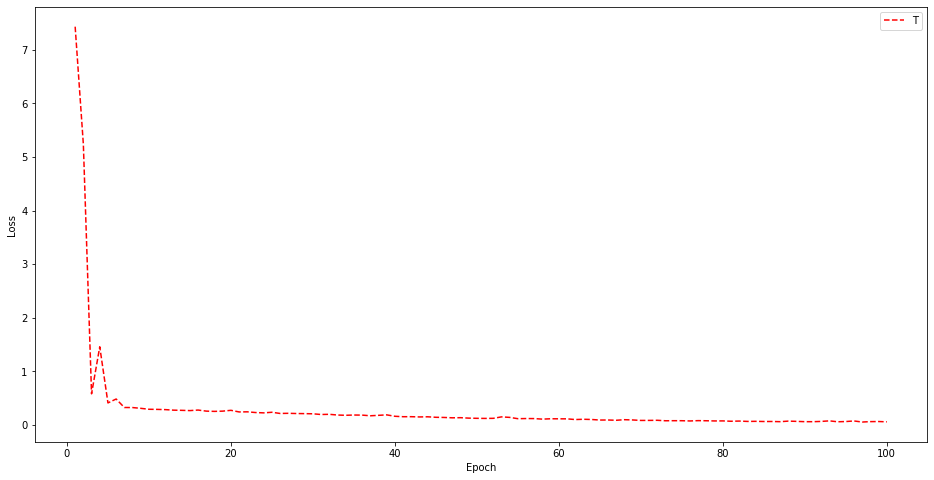

In [28]:
# Plot epoch vs loss
# Get training and test loss histories
# loss dropped fast in frist 100 epoches
fig = plt.figure(figsize=(16,8))
training_loss = loss_list[:100]

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
#plt.plot(epoch_count, test_loss, 'b-')
plt.legend('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [601]:
rescale_dataset(y_predi,scales_1k,1000)[:,0]

array([4588.68793202, 4702.52452228, 4316.37653738, 4599.82322639,
       4700.52225502, 4723.49506586, 4642.21586983, 4804.10449159,
       4676.91539002, 3987.6633827 , 4633.20619797, 4400.08606135,
       4067.51647735, 4557.39295077, 4750.9802185 , 4038.18620773,
       4817.58468104, 4754.67957675, 4791.64325028, 4285.03751201,
       4647.34942732, 4044.1159408 , 4650.90982188, 4725.85555124,
       4785.33051156, 4647.90401124, 4697.42553367, 4806.3666402 ,
       4645.2716527 , 4765.7696455 , 4035.99417387, 4525.18855937,
       4021.95880309, 4822.25648143, 4778.42221502, 4728.38601546,
       4786.82307444, 4842.89725428, 4701.0710657 , 4208.45137492,
       4525.23595355, 4808.65827689, 4671.12278507, 4409.11519911,
       4377.71570198, 4481.61634663, 4490.38663862, 4602.99777637,
       4782.92106519, 4573.72292923, 4569.30707406, 4823.85542813,
       4674.79607044, 4479.27474685, 4101.22889349, 4177.16119188,
       4777.35380467, 4666.88490938, 4833.11091341, 4349.54547

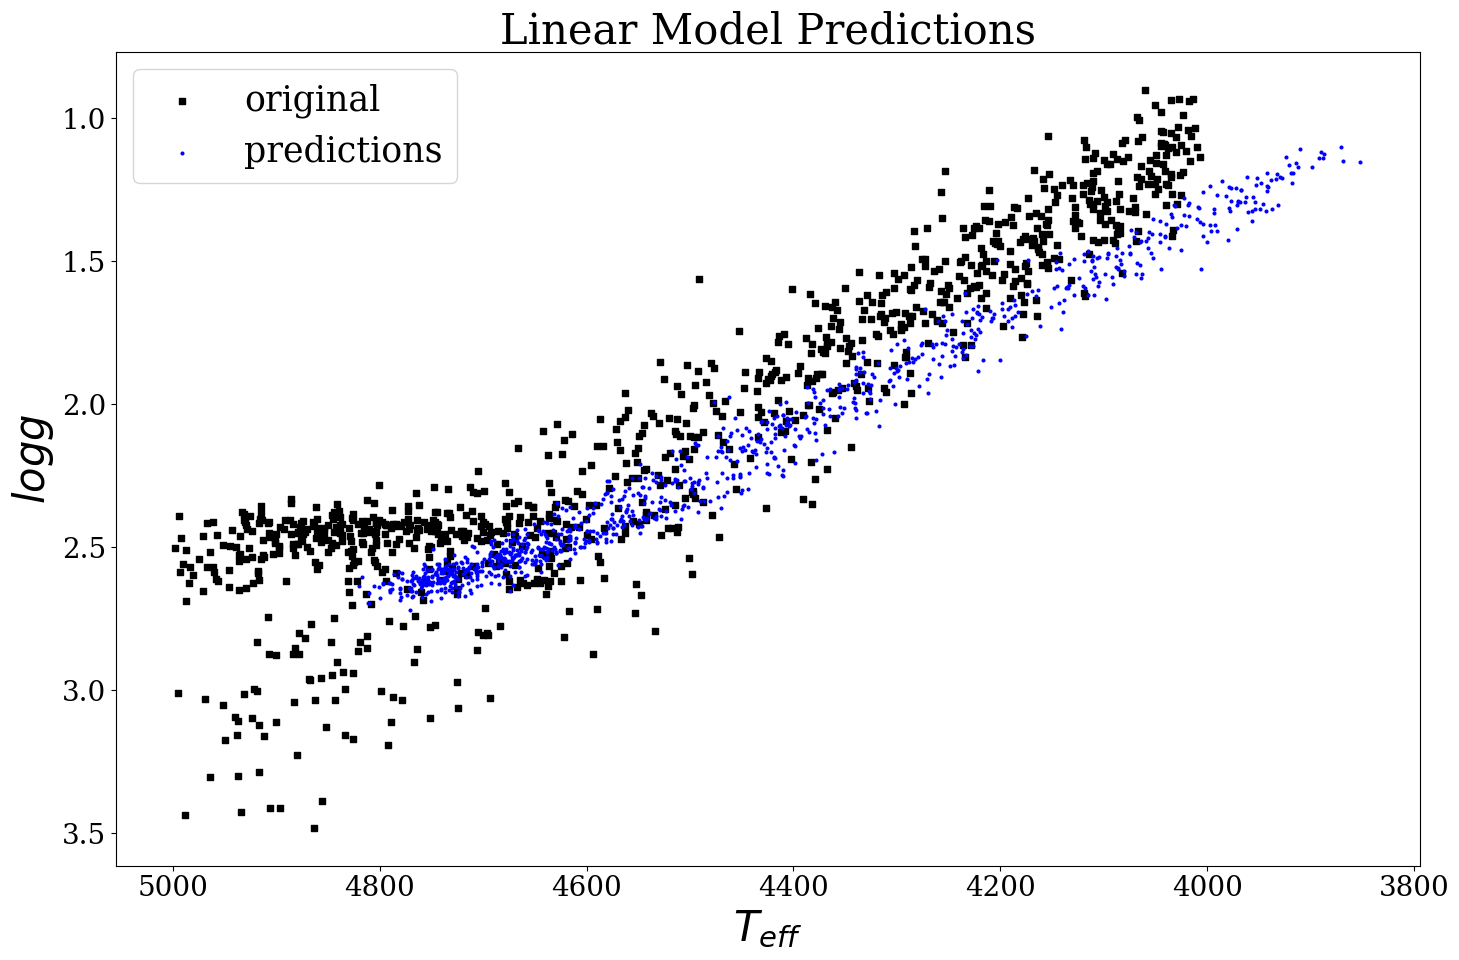

In [29]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

eps='0.01'
fig = plt.figure(figsize=(15, 10), dpi=100)
plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})
ax = plt.gca()
plt.scatter(y[:,0],y[:,1],marker= ",",s=15,c='black', rasterized=True,
            label='original')
plt.scatter(rescale_dataset(y_predi,scales_1k,1000)[:,0],rescale_dataset(y_predi,scales_1k,1000)[:,1],marker=".",s=15,c='blue', rasterized=True,
            label='predictions')
# plt.scatter(adv_pred_fgsm[:,0],adv_pred_fgsm[:,1],marker="^",s=15,c='red', rasterized=True,
#             label='attacked predictions')
plt.xlabel('$T_{eff}$', fontsize=30)
plt.ylabel('$log{g}$', fontsize=30)
plt.title('Linear Model Predictions', fontsize=30)
plt.legend(loc='best', prop={'size':25})
ax.invert_xaxis()
ax.invert_yaxis()

plt.tight_layout()
plt.show()

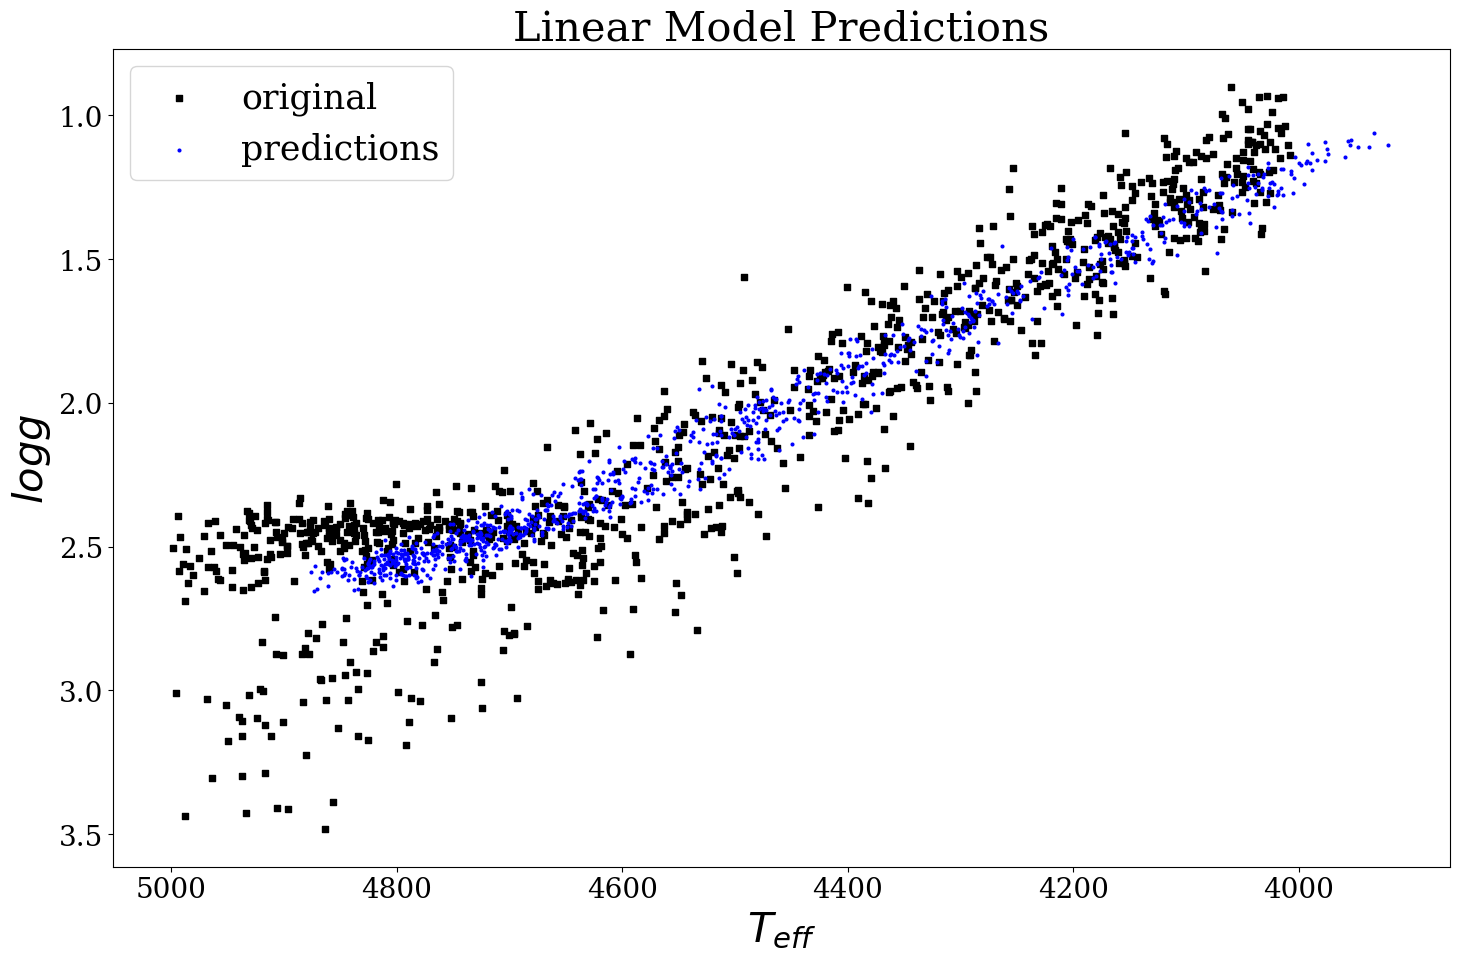

In [612]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

eps='0.01'
fig = plt.figure(figsize=(15, 10), dpi=100)
plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})
ax = plt.gca()
plt.scatter(y[:,0],y[:,1],marker= ",",s=15,c='black', rasterized=True,
            label='original')
plt.scatter(rescale_dataset(y_predi,scales_1k,1000)[:,0],rescale_dataset(y_predi,scales_1k,1000)[:,1],marker=".",s=15,c='blue', rasterized=True,
            label='predictions')
# plt.scatter(adv_pred_fgsm[:,0],adv_pred_fgsm[:,1],marker="^",s=15,c='red', rasterized=True,
#             label='attacked predictions')
plt.xlabel('$T_{eff}$', fontsize=30)
plt.ylabel('$log{g}$', fontsize=30)
plt.title('Linear Model Predictions', fontsize=30)
plt.legend(loc='best', prop={'size':25})
ax.invert_xaxis()
ax.invert_yaxis()

plt.tight_layout()
plt.show()

# Adverserial Attacks
* Attack on flux 

### FGSM Attack
*perturbed_image=image+epsilon∗sign(data_grad)=x+ϵ∗sign(∇xJ(θ,x,y))

In [98]:
size = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02] # 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

In [203]:
# FGSM attack code
# input original flux and output 
import torch.nn.functional as F
def fgsm_attack(epsilon, eval_dl):
    for flux,target in eval_dl:
        flux = torch.tensor(flux,requires_grad=False)
        target = torch.tensor(target,requires_grad=False)
        delta = torch.zeros_like(flux, requires_grad=True)
        # Forward pass the data through the model
        output = model(flux+delta)
        # Calculate the loss
        loss =  torch.nn.MSELoss()(output, target)
        #loss1 = torch.nn.MSELoss()(model(X+delta), y)
        # Zero all existing gradients
        #model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward()
        # Collect datagrad
        data_grad = delta.grad.data
        # Collect the element-wise sign of the data gradient
        sign_data_grad = data_grad.detach().sign()
        #print(sign_data_grad)
        # Create the perturbed image by adjusting each pixel of the input image
        perturbed_flux = flux + epsilon*sign_data_grad
        print(perturbed_flux-flux)
        # Return the perturbed image
    return perturbed_flux

In [205]:
x_perturbed_fgsm = fgsm_attack(0.01,eval_dl)

tensor([[ 0.0099999998, -0.0099999998, -0.0099999998,  ...,
          0.0099999998,  0.0099999998,  0.0099999998],
        [ 0.0099999998, -0.0099999998, -0.0099999998,  ...,
          0.0099999998,  0.0099999998,  0.0099999998],
        [ 0.0099999998, -0.0099999998, -0.0099999998,  ...,
          0.0099999998,  0.0099999998,  0.0099999998],
        ...,
        [ 0.0099999998, -0.0099999998, -0.0099999998,  ...,
          0.0099999998,  0.0099999998,  0.0099999998],
        [ 0.0099999998, -0.0099999998, -0.0099999998,  ...,
          0.0099999998,  0.0099999998,  0.0099999998],
        [ 0.0099999998, -0.0099999998, -0.0099999998,  ...,
          0.0099999998,  0.0099999998,  0.0099999998]])


/Users/nhuang37/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/nhuang37/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [207]:
y_predi_fgsm = model(x_perturbed_fgsm)
y_predi_fgsm.shape

torch.Size([1000, 3])

In [208]:
targets_1k.shape

torch.Size([1000, 3])

In [211]:
getrmse(y_predi_fgsm, model(inputs_1k))

4.1960297

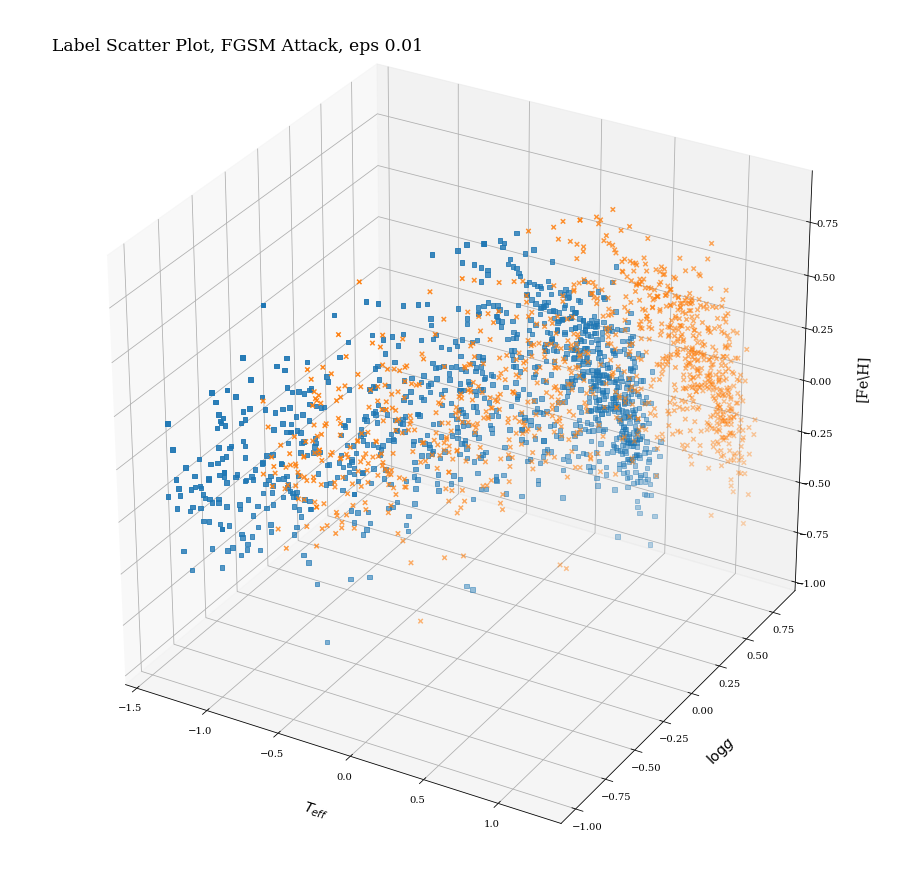

In [212]:
# distribution of 1000 labels in original space
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111,projection='3d')
ax.set_xlabel('$T_{eff}$',fontsize='x-large',labelpad=20)
ax.set_ylabel('$\log g$',fontsize='x-large',labelpad=20)
ax.set_zlabel('[Fe\H]',fontsize='x-large',labelpad=20)
ax.text2D(0.05, 0.95, 'Label Scatter Plot, FGSM Attack, eps 0.01', transform=ax.transAxes,fontsize='xx-large')

#rescaled_y_predi_fgsm = rescale_dataset(y_predi_fgsm.detach().numpy(),scales_1k,1000)

ax.scatter(model(inputs_1k)[:,0],model(inputs_1k)[:,1],model(inputs_1k)[:,2],marker='s')
ax.scatter(y_predi_fgsm[:,0],y_predi_fgsm[:,1],y_predi_fgsm[:,2],marker='x')

#### FGSM with Various Step Size

In [213]:
fgsm_dict = {}
for epsilon in size:
    fgsm_dict[epsilon] = model(fgsm_attack(epsilon,eval_dl))

/Users/nhuang37/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/nhuang37/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


tensor([[ 0.0010000000, -0.0010000000, -0.0010000000,  ...,
          0.0010000000,  0.0010000000,  0.0010000000],
        [ 0.0010000000, -0.0010000000, -0.0010000000,  ...,
          0.0010000000,  0.0010000000,  0.0010000000],
        [ 0.0010000000, -0.0010000000, -0.0010000000,  ...,
          0.0010000000,  0.0010000000,  0.0010000000],
        ...,
        [ 0.0010000000, -0.0010000000, -0.0010000000,  ...,
          0.0010000000,  0.0010000000,  0.0010000000],
        [ 0.0010000000, -0.0010000000, -0.0010000000,  ...,
          0.0010000000,  0.0010000000,  0.0010000000],
        [ 0.0010000000, -0.0010000000, -0.0010000000,  ...,
          0.0010000000,  0.0010000000,  0.0010000000]])
tensor([[ 0.0020000001, -0.0020000001, -0.0020000001,  ...,
          0.0020000001,  0.0020000001,  0.0020000001],
        [ 0.0020000001, -0.0020000001, -0.0020000001,  ...,
          0.0020000001,  0.0020000001,  0.0020000001],
        [ 0.0020000001, -0.0020000001, -0.0020000001,  ...,
      

In [214]:
fgsm_dict.keys()

dict_keys([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02])

## Random Attack on Linear Model

In [109]:
size = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02] #0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

In [110]:
import random
def random_perturb(eps, x):
    random_sign = np.array([random.choice([-1, 1]) for i in x.flatten()]).reshape(x.shape)
    x_rand = x + eps*random_sign
    return x_rand

In [111]:
inputs_1k.sum()

tensor(7150347.)

In [112]:
x_perturbed_rand = random_perturb(0.01,inputs_1k.detach().numpy())
x_perturbed_rand.sum()

7150373.321111526

In [116]:
x_perturbed_rand[0][2800:3350] - x[0][2800:3350]

array([-0.01, -0.01,  0.01, -0.01,  0.01,  0.01, -0.01, -0.01,  0.01,
        0.01, -0.01, -0.01, -0.01,  0.01, -0.01,  0.01,  0.01,  0.01,
        0.01,  0.01, -0.01, -0.01, -0.01, -0.01,  0.01,  0.01, -0.01,
        0.01,  0.01, -0.01,  0.01, -0.01,  0.01, -0.01, -0.01,  0.01,
        0.01, -0.01,  0.01,  0.01,  0.01, -0.01, -0.01,  0.01, -0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01, -0.01, -0.01, -0.01,
        0.01,  0.01,  0.01, -0.01,  0.01, -0.01, -0.01,  0.01, -0.01,
       -0.01,  0.01,  0.01, -0.01, -0.01,  0.01, -0.01, -0.01,  0.01,
        0.01, -0.01, -0.01, -0.01,  0.01,  0.01, -0.01,  0.01,  0.01,
        0.01, -0.01, -0.01,  0.01,  0.01,  0.01,  0.01, -0.01,  0.01,
       -0.01, -0.01,  0.01, -0.01,  0.01,  0.01, -0.01, -0.01, -0.01,
       -0.01,  0.01,  0.01,  0.01, -0.01, -0.01,  0.01, -0.01,  0.01,
       -0.01,  0.01,  0.01, -0.01,  0.01,  0.01,  0.01, -0.01, -0.01,
        0.01,  0.01,  0.01,  0.01,  0.01, -0.01,  0.01, -0.01, -0.01,
       -0.01, -0.01,

In [118]:
#perturbed flux
# for each step size, stores a flux matrix of 1000*8576
random_dict = {}
for eps in size:
    random_dict[eps] = random_perturb(eps,inputs_1k.detach().numpy()) #inputs_1k_np)

In [119]:
# predicted labels on model using perturbed flux
y_random_dict = {}

for key, value in random_dict.items():
    y_predi_1k_rand = []
    for i in range(1000):
        y_predi_1k_rand.append(model.weight.detach().numpy()@(value[i]))
    y_random_dict[key] = y_predi_1k_rand
#y_predi_1k= torch.tensor(np.array(y_predi_1k))

In [120]:
for eps in y_random_dict.keys():
    y_random_dict[eps] = np.array(y_random_dict[eps])

In [121]:
y_perturbed_rand = y_random_dict[0.01]
y_perturbed_rand

array([[ 0.09350555,  0.17323654, -0.15966691],
       [ 0.31061598,  0.35245154, -0.2402344 ],
       [-0.53040396, -0.39241922, -0.43890246],
       ...,
       [ 0.50306092,  0.49067082, -0.29676484],
       [-0.16297428, -0.01472804, -0.13879787],
       [-0.00552965,  0.19841551,  0.22776648]])

In [636]:
tr_labels_1k[0]

array([ 4.4800527e+03,  1.8559592e+00, -2.9007456e-01], dtype=float32)

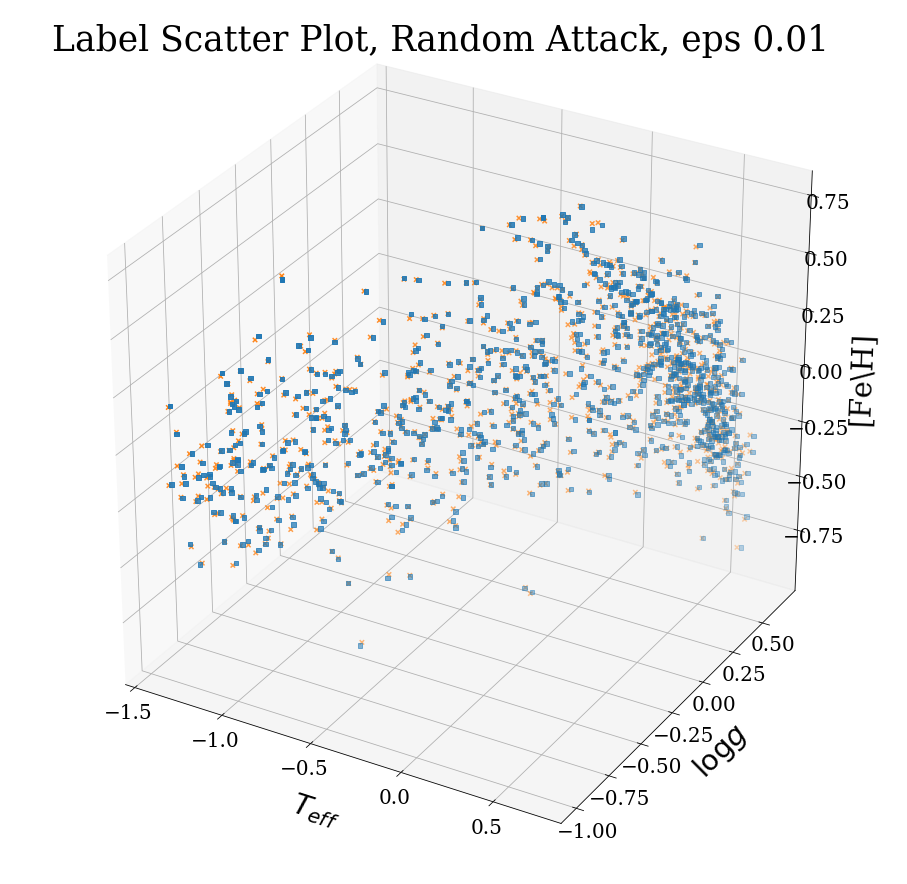

In [122]:
# distribution of 1000 labels in original space
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111,projection='3d')
ax.set_xlabel('$T_{eff}$',fontsize='x-large',labelpad=20)
ax.set_ylabel('$\log g$',fontsize='x-large',labelpad=20)
ax.set_zlabel('[Fe\H]',fontsize='x-large',labelpad=20)
ax.text2D(0.05, 0.95, 'Label Scatter Plot, Random Attack, eps 0.01', transform=ax.transAxes,fontsize='xx-large')

#rescaled_y_perterbed_rand = rescale_dataset(y_perterbed_rand,scales_1k,1000)

ax.scatter(model(inputs_1k)[:,0],model(inputs_1k)[:,1],model(inputs_1k)[:,2],marker='s')
ax.scatter(y_perturbed_rand[:,0],y_perturbed_rand[:,1],y_perturbed_rand[:,2],marker='x')
#ax.scatter(y_perterbed[:,1],y_perterbed[:,2],y_perterbed[:,3],marker='x',s=128)

### Plot Label Distribution

In [248]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_dist(eps,y_predi, pred_bad, attack_dict):
    fig = plt.figure(figsize=(15, 10), dpi=100)
    plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})
    ax = plt.gca()
    plt.scatter(y_predi[:,0],y_predi[:,1],marker= ",",s=15,c=np.clip( y_predi[:,2] , -1.5, 0.25), rasterized=True,
                label='original')
    #idx = [i for i, d in enumerate(attack_dict.keys()) if d==eps][0]
    plt.scatter(pred_bad[:,0],pred_bad[:,1],marker="^",s=15,c=np.clip(pred_bad[:,2] , -1.5, 0.25), rasterized=True,
                label='attack')
    plt.xlabel('$T_{eff}$', fontsize=30)
    plt.ylabel('$log{g}$', fontsize=30)
    plt.title('Label Distribution, step_size='+str(eps), fontsize=30)
    plt.legend(loc='best')
    ax.invert_xaxis()
    ax.invert_yaxis()
    #colorbar 
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax, ticks=[-1.5, -1.25, -1.0, -0.75, -0.5, -0.25, 0., 0.25])
    cbar.ax.set_yticklabels(["<-1.5", '-1.25', '-1.0', '-0.75', '-0.5', '-0.25', '0.0', ">0.25"])   
    cbar.set_clim(vmin=-1.5, vmax=0.25)
    cbar.ax.tick_params(labelsize=25)
    cbar.set_label("$[Fe/H]$", size=30)

    plt.tight_layout()
    
    
    
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_dist_2d(eps,y_predi, pred_bad, attack_dict):
    fig = plt.figure(figsize=(15, 10), dpi=100)
    plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})
    ax = plt.gca()
    plt.scatter(y[:,0],y[:,1],marker= ".",s=15,c='grey', rasterized=True,
            label='original')
    plt.scatter(y_predi[:,0],y_predi[:,1],marker= ",",s=15,c='blue', rasterized=True,
                label='predictions')
    idx = [i for i, d in enumerate(attack_dict.keys()) if d==eps][0]
    plt.scatter(pred_bad[:,0],pred_bad[:,1],marker="^",s=15,c='red', rasterized=True,
                label='attacked predictions')
    plt.xlabel('$T_{eff}$', fontsize=30)
    plt.ylabel('$log{g}$', fontsize=30)
    #plt.title('Label Distribution, step_size='+str(eps), fontsize=30)
    plt.legend(markerscale=4,loc='best', prop={'size':30})
    ax.invert_xaxis()
    ax.invert_yaxis()

    plt.tight_layout()

In [249]:
y_predi_fgsm

tensor([[ 6.1174082756e-01,  3.3970707655e-01, -3.5876609385e-02],
        [ 8.3273267746e-01,  5.1886492968e-01, -1.1886992306e-01],
        [ 5.8979354799e-04, -2.2037310898e-01, -3.1490793824e-01],
        ...,
        [ 1.0223184824e+00,  6.5946710110e-01, -1.6353961825e-01],
        [ 3.6962237954e-01,  1.5533170104e-01,  4.0634744801e-03],
        [ 5.2719187737e-01,  3.7596777081e-01,  3.5736119747e-01]])

### 2d label distribution
<a id='2d_plot'></a>

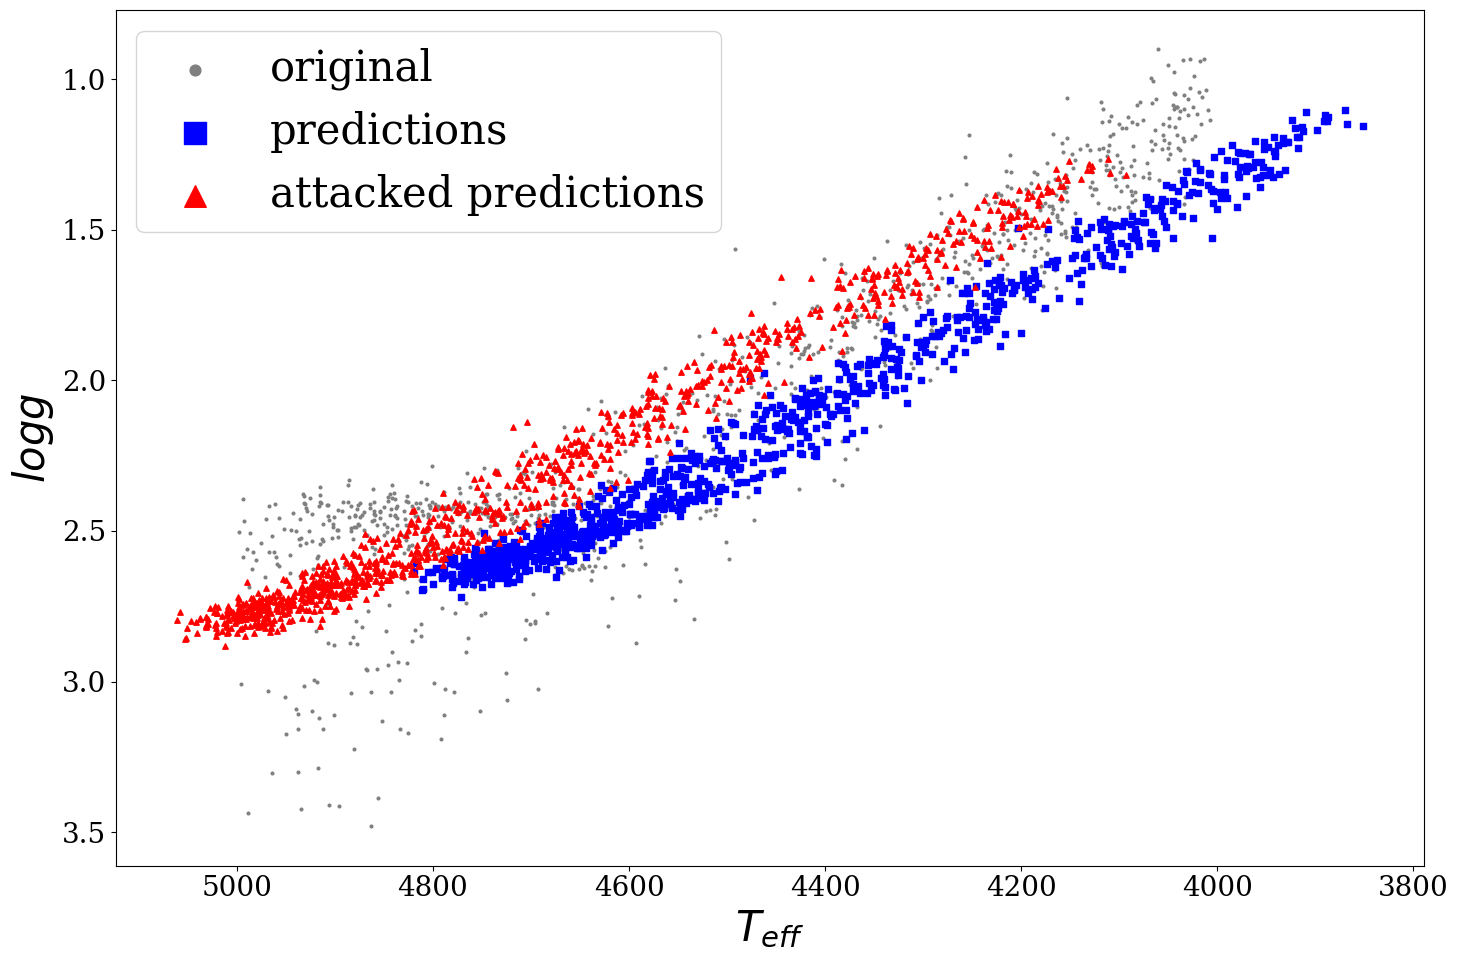

In [250]:
plot_dist_2d(0.01,rescale_dataset(y_predi,scales_1k,1000),rescale_dataset(y_predi_fgsm,scales_1k,1000), fgsm_dict)

### One example attack Plot
<a id= 'example_attack_plot' ></a>

In [218]:
from numpy import linalg as LA
def worst_attack_cases(y_pred,y_true,k=1):
    diff = LA.norm((y_pred-y_true),axis=1) 
    #print(diff.argsort()[::-1])
    return diff.argsort()[::-1][:k]

In [254]:
plot_idxs_fgsm_1k = worst_attack_cases(y_predi_fgsm,targets_1k,1).tolist()
plot_idxs_fgsm_1k

[500]

In [132]:
#load all true fluxes
import pickle
with open('/Users/nhuang37/Desktop/NYU DS/Yr 2 Sem1/Capstone/AstroNN/rerun_1k_unscaled/true_flux_1557.pkl', 'rb') as f:
    true_flux = pickle.load(f)

In [133]:
#assume (key_i, value_i) => (x_i, y_i)??? double-check with Greg
true_fluxes = np.array(list(true_flux.values()))

In [134]:
true_fluxes.shape

(1000, 8575)

In [255]:
idx = plot_idxs_fgsm_1k

In [256]:
#find nearest neighbors
from numpy import linalg as LA
def dist(label,flux, idx,k):
    dist_all = LA.norm((label - label[idx]), axis=1) 
    k_neigh = dist_all.argsort()[1:k+1] #get the closest k neighbours
    dist_label = LA.norm((label[k_neigh] - label[idx]), axis=1)
    dist_flux = LA.norm((flux[k_neigh] - flux[idx]), axis=1)  
    return k_neigh, dist_label, dist_flux

In [257]:
labels[0]

array([-0.03450568, -0.2199393 , -0.49218544], dtype=float32)

In [258]:
k_neigh, dist_label, dist_flux = dist(labels,true_fluxes,idx,10) #debatable whether use the true label or predictions
k_neigh

array([780,  67, 426, 960, 400, 803,  29, 369, 883, 750])

In [259]:
#generate neighbor points 
from astroNN.apogee import chips_pix_info, gap_delete, apogee_continuum, bitmask_boolean
from numpy import linalg as LA

def neighbor_delta_flux(true_fluxes, idx, k_idx, model='Linear'):
    '''
    true_fluxes: physical model fluxes
    idx: the id of star of interest
    k_idx: the id of k neighbors of the label space
    model: NN/Linear/Cannon
    '''
    delta_flux = true_fluxes[k_idx] - true_fluxes[idx] 
    if model=='NN':
        Q = LA.norm(np.ones(7514)*0.01)        
        delta_flux = gap_delete(delta_flux, dr=14) #shape (10, 7514), true_flux has 8575 while NN needs 7514 as input
    else: #linear or Cannon, input already 8575
        Q = LA.norm(np.ones(8575)*0.01)
    delta_flux_n = delta_flux * Q / LA.norm(delta_flux,axis=1).reshape(-1,1)
    return delta_flux_n

In [260]:
k_idx = k_neigh
delta_flux_neighbors = neighbor_delta_flux(true_fluxes,idx,k_idx, model='Linear') 

In [261]:
delta_flux_neighbors.shape

(10, 8575)

In [262]:
import random
def neighbor_random_perturb(fluxes,idx, k=10):
    '''
    fluxes: data fluxes #for NN: len=7514, for Cannon/Linear: len = 8575
    idx: the id of star of interest
    k: number of random perturbation points
    model: NN/Linear/Cannon
    '''
    eps = 0.01
    result = []
    for i in range(k):
        random_sign = np.array([random.choice([-1, 1]) for i in fluxes[idx]])
        result.append(eps*random_sign)
    return np.array(result)

In [263]:
delta_flux_random = neighbor_random_perturb(x,929, k=10)

In [264]:
delta_flux_neighbors.shape

(10, 8575)

In [265]:
delta_flux_random.shape

(10, 8575)

In [266]:
#evaluate the physcial perturbation on the label space
# per example predictions
# input raw input data then add bias together and convert to torch
x_predi_fsgm_p = torch.from_numpy(x[idx]+delta_flux_neighbors).type(torch.FloatTensor)
x_predi_fsgm_r = torch.from_numpy(x[idx]+delta_flux_random).type(torch.FloatTensor)
y_predi_fgsm_p  = model(x_predi_fsgm_p)
y_predi_fgsm_r = model(x_predi_fsgm_r)
#torch.from_numpy(flux_1k_bias).type(torch.FloatTensor)

In [267]:
rescale_dataset(y_predi_fgsm_p,scales_1k,10)

array([[ 4.74099072e+03,  2.64975333e+00, -7.14068413e-02],
       [ 4.79398633e+03,  2.69443464e+00, -1.48093790e-01],
       [ 4.70731006e+03,  2.64078069e+00,  2.38634646e-03],
       [ 4.79827051e+03,  2.71775174e+00, -1.33555740e-01],
       [ 4.67990088e+03,  2.59767246e+00, -4.63619828e-03],
       [ 4.71635596e+03,  2.65335321e+00, -3.86397541e-03],
       [ 4.68917773e+03,  2.60012341e+00, -1.73133835e-02],
       [ 4.68448828e+03,  2.58504391e+00, -2.89663300e-02],
       [ 4.69765869e+03,  2.55306625e+00, -1.19030684e-01],
       [ 4.73746387e+03,  2.59543920e+00, -1.50057718e-01]])

In [268]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import ConvexHull, convex_hull_plot_2d

def plot_one_example(eps,y, y_predi,pred_bad, random_pred, attack_dict,attack_eg, plot_idxs,
                     points_random, points_neighbor, method='FGSM'):
    fig = plt.figure(figsize=(15, 10), dpi=100)
    plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':16})
    ax = plt.gca()
    plt.scatter(y[plot_idxs,0],y[plot_idxs,1],marker= ",",s=120,rasterized=True,c='black',
               label='original') ##original should be the original y, not predictions?
    plt.scatter(y_predi[plot_idxs,0],y_predi[plot_idxs,1],marker= "D",s=120,rasterized=True,c='blue',
                label='original prediction') ##original should be the original y, not predictions?
    plt.scatter(pred_bad[plot_idxs,0],pred_bad[plot_idxs,1],marker="^",s=120,c='red' ,rasterized=True,
                label=method+' attack')
    #plt.scatter(attack_eg[0],attack_eg[1],marker= "X",s=80,c='orange',rasterized=True,label='per_example') #c = np.clip(attack_eg[19], -1.5, 0.25) throws out of range error
    
    #plot random perturb and k-neighbors
    plt.scatter(points_random[:,0], points_random[:,1], marker='.', s=120,c='green', rasterized=True,
                label='random perturbation')
    plt.scatter(points_neighbor[:,0], points_neighbor[:,1], marker='*', s=120,c='purple', rasterized=True,
                label='physical attack')
   #plt config
    plt.xlabel('$T_{eff}$', fontsize=30)
    plt.ylabel('$log{g}$', fontsize=30)
    #plt.title('Star_ID=359 Attack Results, step_size='+str(eps)+',method='+method, fontsize=30)
    plt.legend(loc='best', prop={'size':25})
    ax.invert_xaxis()
    ax.invert_yaxis()

    plt.tight_layout()


In [269]:
rescale_dataset(y_predi_fgsm,scales_1k,1000)
#y_predi_fgsm.shape

array([[ 4.77796289e+03,  2.40452766e+00, -1.20074950e-01],
       [ 4.87983691e+03,  2.58013916e+00, -1.50994420e-01],
       [ 4.49623145e+03,  1.85553384e+00, -2.24029154e-01],
       ...,
       [ 4.96723340e+03,  2.71795845e+00, -1.67636305e-01],
       [ 4.66635010e+03,  2.22380185e+00, -1.05195120e-01],
       [ 4.73898730e+03,  2.44007063e+00,  2.64273062e-02]])

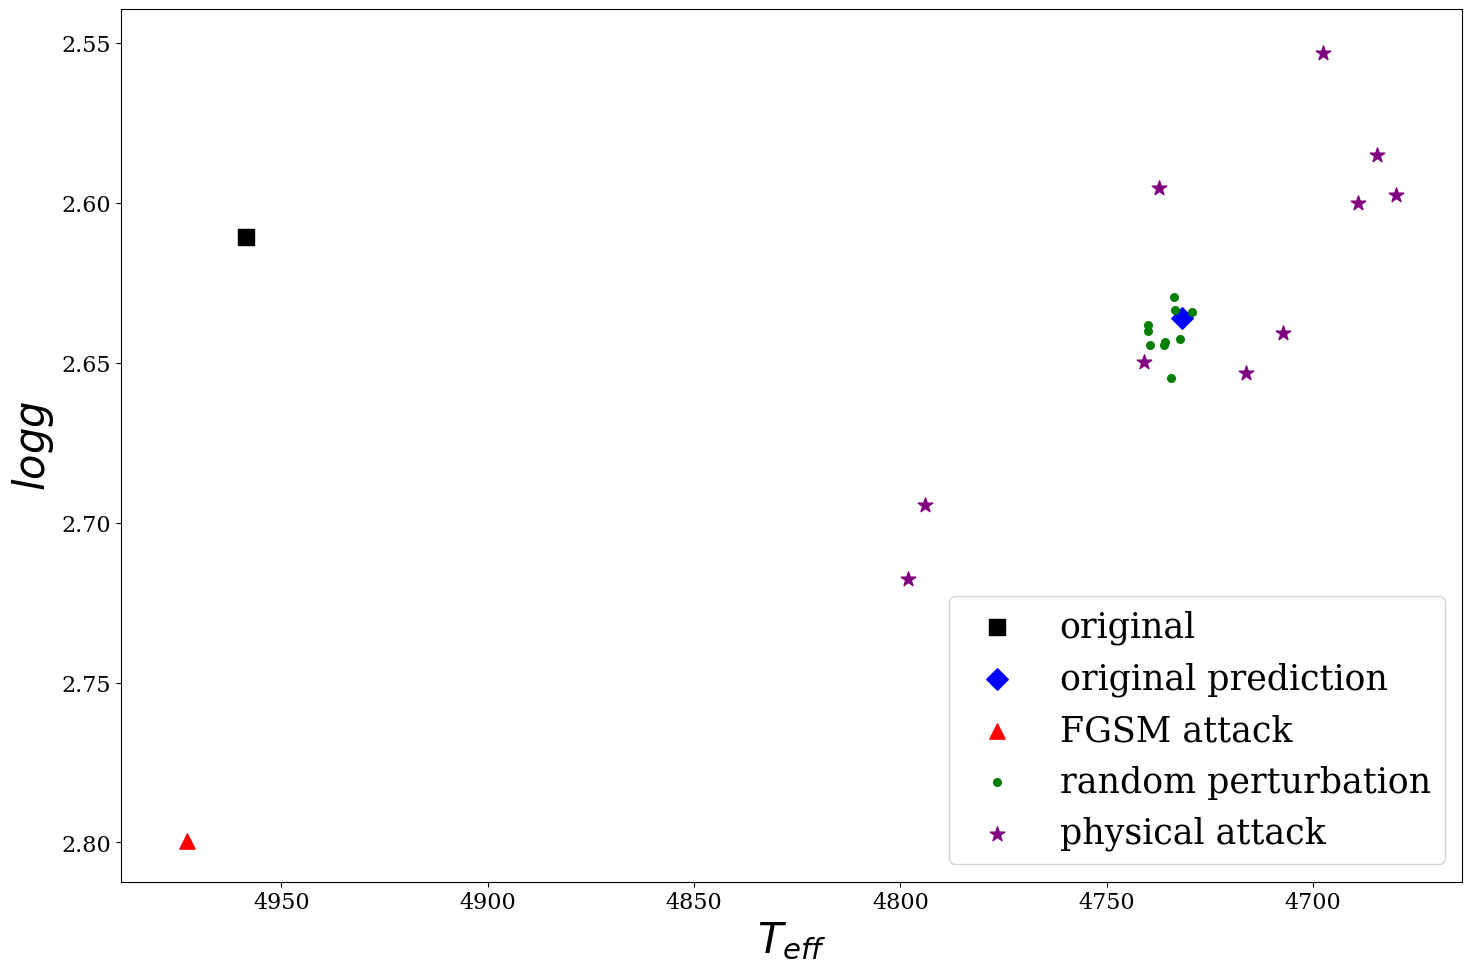

In [270]:
plot_idxs = [500] #one example only
y_predi_eg = y_predi_fgsm[500] #find the per-example attack result array (from k-examples)
plot_one_example(0.01,y,rescale_dataset(y_predi,scales_1k,1000),rescale_dataset(y_predi_fgsm,scales_1k,1000), rescale_dataset(y_perturbed_rand,scales_1k,1000), 
             fgsm_dict,y_predi_eg, plot_idxs,rescale_dataset(y_predi_fgsm_r,scales_1k,10),rescale_dataset(y_predi_fgsm_p,scales_1k,10),
             method='FGSM')
#plot_dist_2d(0.01,y_predi_1k, y_predi_fgsm, fgsm_dict)

###  Banner Plot
<a id= 'banner_plot' ></a>

Raw Spectra detected, astroNN has deleted the gap automatically
Raw Spectra detected, astroNN has deleted the gap automatically


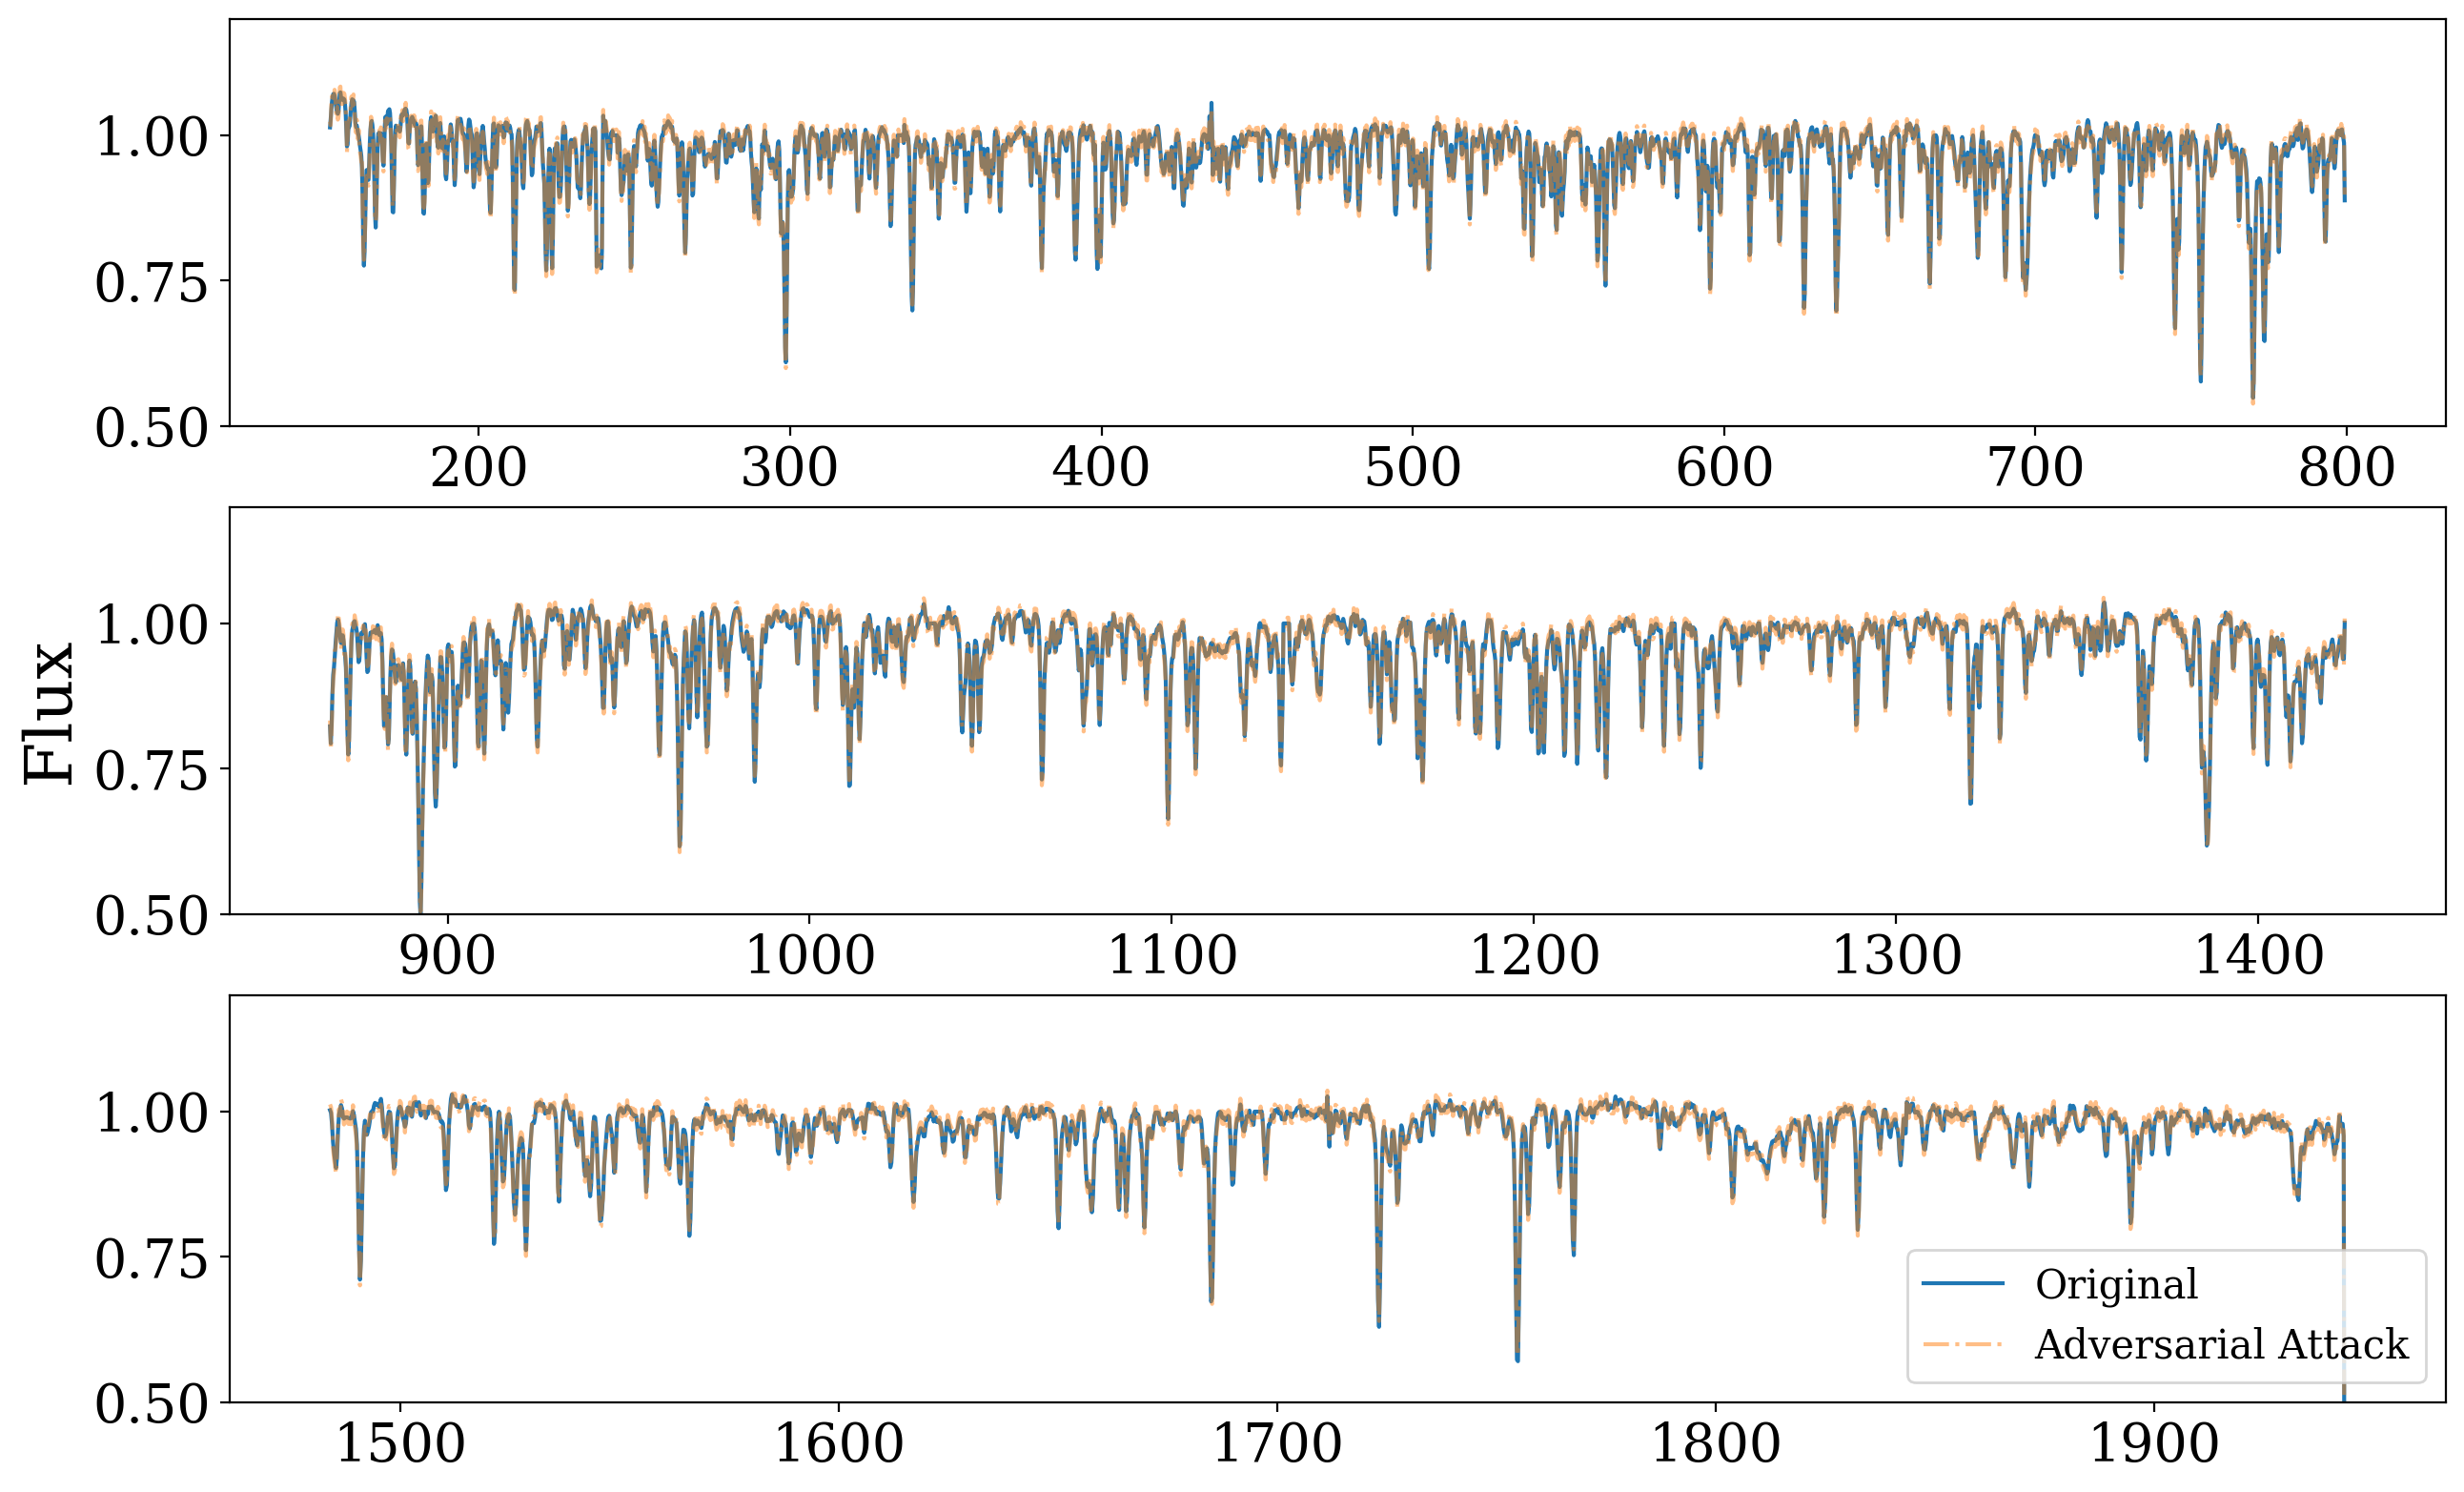

In [237]:
#plot the original + attack flux
from astroNN.apogee.chips import wavelength_solution, chips_split
plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})
lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=14)

lambda_blue -= 15000
lambda_green -= 15000
lambda_red -= 15000
worst_idx = 500

fig = plt.figure(figsize=(15, 13), dpi=200)
blue, green, red = chips_split(x[worst_idx], dr=14) 
blue, green, red = blue[0], green[0], red[0]
#blue_bad, green_bad, red_bad = chips_split(fgsm_dict.get(0.01)[worst_idx], dr=14) #universal
blue_bad, green_bad, red_bad = chips_split(x_perturbed_fgsm[worst_idx], dr=14)  #per_example
blue_bad, green_bad, red_bad= blue_bad[0], green_bad[0], red_bad[0]

#fig.suptitle('APOGEE Spectra Example (ID='+str(worst_idx)+')' , fontsize=25)
ax1 = fig.add_subplot(411)
ax1.plot(lambda_blue, blue, linewidth=1.5,rasterized=True, label='Original')
ax1.plot(lambda_blue, blue_bad,'-.', linewidth=1.5,rasterized=True, label='Adversarial Attack', alpha=0.5 )
ax1.set_ylim((0.5, 1.2))
ax2 = fig.add_subplot(412)
ax2.set_ylabel('Flux', fontsize=25)
ax2.plot(lambda_green, green, linewidth=1.5,rasterized=True, label='Original')
ax2.plot(lambda_green, green_bad, '-.',linewidth=1.5,rasterized=True, label='Adversarial Attack', alpha=0.5)
ax2.set_ylim((0.5, 1.2))
ax3 = fig.add_subplot(413)
ax3.plot(lambda_red, red, linewidth=1.5,rasterized=True, label='Original')
ax3.plot(lambda_red, red_bad,'-.', linewidth=1.5,rasterized=True, label='Adversarial Attack', alpha=0.5)
ax3.set_ylim((0.5, 1.2))
ax3.legend(loc='lower right',prop={'size': 15})

### RMSE of Random Attack

In [182]:
y_random_dict[0.01][0]

array([ 0.09350555,  0.17323654, -0.15966691])

In [239]:
# scale predicted value perturbed by random attack back to {-1,1} scale (with 19 step sizes)
rmse_pred_random = []
for eps in y_random_dict.keys(): 
    #y_predi_1k_rand_scaled,scales = scale_dataset(np.array(y_random_dict[eps]))
    rmse_pred_random.append(getrmse(torch.tensor(y_random_dict[eps]).double(),targets_1k.double()))
rmse_pred_random

[0.1951856548515703,
 0.2756979107730464,
 0.338363051012317,
 0.3920972503678223,
 0.4316680547455485,
 0.47549496099774036,
 0.5149207980278767,
 0.5485320368609726,
 0.579849273020169,
 0.6102581668653249,
 0.8586360262167325]

### RMSE of scaled FGSM

In [238]:
# compute rmse (fgsm)
rmse_pred_fgsm_scaled = []
for eps in fgsm_dict.keys():
    rmse_pred_fgsm_scaled.append(getrmse(torch.tensor(fgsm_dict[eps]).double(),targets_1k.double()))
rmse_pred_fgsm_scaled 

/Users/nhuang37/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


[1.407946620727684,
 1.9346364388758714,
 2.3459581982551905,
 2.6952058569302335,
 3.0041279282353477,
 3.2841198053172684,
 3.5420555909036304,
 3.7824355569998382,
 4.0084230270417045,
 4.222335994120876,
 5.952716298182036]

In [186]:
torch.tensor(np.array(y_random_dict[0.01])).shape

torch.Size([1000, 3])

### plot MSE w.r.t step size (add more larger step: 0.1-1)

In [192]:
targets_1k[0]

tensor([])

In [194]:
mse_norm = getrmse(torch.tensor(y_predi).double(),targets_1k.double())

/Users/nhuang37/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [195]:
mse_norm

7.260122604973283

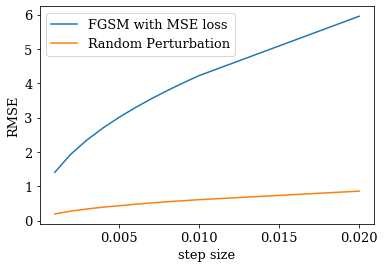

In [272]:
#plot rescale RMSE
#plot RMSE w.r.t step size (add more larger step: 0.1-1)
plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':13})
#plt.plot(size, scale_rmse_pred_bad_pgd,label='PGD') 
plt.plot(size[:11], rmse_pred_fgsm_scaled ,label='FGSM with MSE loss')
plt.plot(size[:11],rmse_pred_random,label='Random Perturbation')
#####horizontal line for normal MSE
#plt.plot(size[:11], [mse_norm]*11, 'r--',label='Original')  ##not comparable as now predicted values are attack target?
plt.xlabel('step size')
plt.ylabel('RMSE')
plt.legend(loc='upper left')
plt.savefig('MSE')
#plt.title('Root Mean Square Error for Different Step Sizes (Scaled)')

In [241]:
rmse_pred_fgsm_scaled[-2]/rmse_pred_random[-2]

6.918934023954954